# <center>Machine Learning Final Project: Imbalance Classification </center>


### Course: Machine Learning I
### Instructor: Dr. Tariq Mahmood
### Submitted by: Saad Ullah Bilal (29416) and Muhammad Zain (29403)

## <center> The target of this project is to discover the impact of using different techniques to address class imbalance (CI) on ML performance</center>

### Importing Necessary libraries

In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from tabulate import tabulate
from pathlib import Path

from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score, precision_score, recall_score, classification_report
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.svm import SVC, OneClassSVM

from imblearn.ensemble import BalancedRandomForestClassifier
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import ClusterCentroids

import warnings
warnings.filterwarnings("ignore")

from ucimlrepo import fetch_ucirepo

from IPython.display import display, HTML

# Use CSS to change the output scrolling setting
display(HTML("<style>.output_scroll { height: auto !important; }</style>"))


### This Function will Load the dataset

In [3]:
def load_dataset(file_path=None, id=None):
    if file_path:
        data = pd.read_csv(file_path)
        print("Data loaded from file at: {}".format(file_path))
        print("Columns in the dataset:")
        print(data.columns.tolist())  # Display column names when loading from a file
    elif id:
        dataset = fetch_ucirepo(id=id)
        data = pd.concat([pd.DataFrame(dataset['data']['features']), pd.DataFrame(dataset['data']['targets'])], axis=1)
        data.columns = list(dataset['data']['features'].columns) + ['target']
        print("Data loaded from UCI repository with ID: {}".format(id))
        print("Columns in the dataset:")
        print(data.columns.tolist())  # Display column names when loading from UCI repository
    else:
        print("Please provide either a file path or a dataset ID.")
        data = None

    if data is not None:
        print("\nTotal columns loaded: {}".format(len(data.columns)))
       # print("First few rows of the dataset:")
       # print(data.head())  # Optionally show the first few rows to inspect the dataset immediately
    return data


This load_dataset function will load the dataset dirently from the UCI ML repositorty and from the device itself as well

### This Function will check if the dataset is imbalance

In [4]:
def check_imbalance(data, target_column_name):
    target_counts = data[target_column_name].value_counts()
    imbalance_ratio = max(target_counts) / min(target_counts)
    
    # Print imbalance information
    if imbalance_ratio > 1.5:
        print("Dataset is imbalanced with an imbalance ratio of {:.2f}".format(imbalance_ratio))
        
        # Identify major and minor classes
        major_class = target_counts.idxmax()
        minor_class = target_counts.idxmin()
        
        # Plot bar chart for major and minor classes
        plt.figure(figsize=(8, 4))
        sns.barplot(x=[major_class, minor_class], y=[target_counts[major_class], target_counts[minor_class]], palette="viridis")
        plt.title(f'Comparison of Major and Minor Classes in {target_column_name}')
        plt.xlabel('Classes')
        plt.ylabel('Count')
        plt.show()
        
        # Print imbalance value counts for major and minor classes
        print(f"{major_class} (Major Class): {target_counts[major_class]}")
        print(f"{minor_class} (Minor Class): {target_counts[minor_class]}")
        print("\n" + "#" * 101 + "\n")
    else:
        print("Dataset is balanced")

- Calculates the imbalance ratio of a target column in a dataset by dividing the count of the most frequent class by the count of the least frequent class.
- Checks if the imbalance ratio is greater than 1.5.
- If the dataset is imbalanced:
    - Prints a message indicating the imbalance ratio.
    - Identifies the major and minor classes.
    - Plots a bar chart to compare the counts of the major and minor classes.
    - Prints the count of each class.
- If the dataset is balanced, prints a message indicating that the dataset is balanced.

### This funciton will convert target to categorical variable

In [5]:
def convert_target_to_categorical(data, target_column='target', bins=3):
    """
    Converts a continuous target column into categorical by discretizing it into bins.
    """
    if data[target_column].dtype in ['float64', 'int32', 'int64']:
        print("Converting target column to categorical.")
        discretizer = KBinsDiscretizer(n_bins=bins, encode='ordinal', strategy='uniform')
        data[target_column] = discretizer.fit_transform(data[[target_column]]).astype(int)
    return data


- Checks if the target column in the dataset is of a continuous type (float or int).
- If the target column is continuous:
    - Prints a message indicating that the target column is being converted to categorical.
    - Uses the KBinsDiscretizer from sklearn to discretize the target column into a specified number of bins (default is 3).
    - Replaces the original target column with the discretized categorical values.
- Returns the modified dataset with the categorical target column.

### This function will clean the data

In [6]:
def clean_data(data, target_column='target', bins=3, encode_target=False):
    numeric_cols = data.select_dtypes(include=[np.number]).columns.tolist()
    categorical_cols = data.select_dtypes(exclude=[np.number]).columns.tolist()

    if encode_target and target_column in data.columns:
        if data[target_column].dtype in ['float64', 'int32', 'int64'] and len(pd.unique(data[target_column])) > bins:
            print("Encoding target as categorical.")
            discretizer = KBinsDiscretizer(n_bins=bins, encode='ordinal', strategy='uniform')
            data[target_column] = discretizer.fit_transform(data[[target_column]].astype(float)).astype(int)

    imputer = SimpleImputer(strategy='mean')
    data[numeric_cols] = imputer.fit_transform(data[numeric_cols])

    scaler = StandardScaler()
    data[numeric_cols] = scaler.fit_transform(data[numeric_cols])

    if categorical_cols:
        encoder = OneHotEncoder(drop='first', sparse_output=False)
        encoded_data = encoder.fit_transform(data[categorical_cols])
        encoded_cols = encoder.get_feature_names_out(categorical_cols)
        data = data.drop(categorical_cols, axis=1)
        data[encoded_cols] = encoded_data

    return data

- Separates the dataset into numeric and categorical columns.
- If encode_target is True and the target column exists:
    - Checks if the target column is continuous and has more unique values than the specified number of bins.
    - If so, discretizes the target column into categorical values using KBinsDiscretizer.
- Imputes missing values in numeric columns using the mean strategy.
- Scales numeric columns using StandardScaler.
- If there are categorical columns:
    - One-hot encodes the categorical columns using OneHotEncoder.
    - Drops the original categorical columns.
    - Adds the encoded columns to the dataset.
- Returns the cleaned and preprocessed dataset.

### This function will do the EDA

In [7]:
def perform_eda(data, target_column='target', correlation_threshold=0.3):
    print("Basic Structure of the Data:")
    print(data.info())
    print("\n" + "#" * 101 + "\n")

    print("Descriptive Statistics for Numeric Data:")
    print(data.describe())
    print("\n" + "#" * 101 + "\n")

    # Improve aesthetics
    sns.set(style="whitegrid", palette="pastel")

    # Calculate the correlation matrix
    correlation_matrix = data.corr()

    # Identify the top 5 features most correlated with the target
    most_correlated = correlation_matrix[target_column].drop(target_column).abs().nlargest(5).index.tolist()

    # Visualize histograms and boxplots for the most correlated numeric features
    for col in most_correlated:
        plt.figure(figsize=(12, 6))

        # Histogram
        print(f"Plotting Histogram for {col}")
        plt.subplot(1, 2, 1)
        sns.histplot(data[col], kde=True, color='skyblue', element="step", stat="density")
        plt.title(f'Histogram of {col}')
        plt.grid(False)  # Turn off the grid

        # Box Plot
        print(f"Plotting Box Plot for {col}")
        plt.subplot(1, 2, 2)
        sns.boxplot(x=data[col], color='lightgreen')
        plt.title(f'Box Plot of {col}')
        plt.grid(False)  # Turn off the grid
        plt.show()

    print("\n" + "#" * 101 + "\n")

    # Missing Values, Unique Values, and Correlation Matrix of Important Columns
    important_columns = most_correlated + [target_column]

    print("Missing Values per Column:")
    print(data[important_columns].isnull().sum())
    print("\n" + "#" * 101 + "\n")

    print("Number of Unique Values per Column:")
    print(data[important_columns].nunique())
    print("\n" + "#" * 101 + "\n")

    print("Correlation Matrix of Important Columns:")
    print("Plotting Correlation Matrix")
    plt.figure(figsize=(10, 8))
    sns.heatmap(data[important_columns].corr(), annot=True, cmap='coolwarm', linewidths=0.5)
    plt.title('Correlation Matrix')
    plt.show()

    print("\n" + "#" * 101 + "\n")


In essence, this function performs exploratory data analysis (EDA) to gain insights into the dataset, focusing on the relationships between the target column and other features.

- Prints basic information about the dataset, including its structure and descriptive statistics.
- Calculates the correlation matrix of the dataset.
- Identifies the top 5 features most correlated with the target column.
- Visualizes the distribution of these correlated features using histograms and box plots.
- Prints information about missing values, unique values, and the correlation matrix for the important columns (i.e., the top correlated features and the target column).

### Dealing with Imbalance via RandomForest method (Algorithmic/Ensemble)

In [8]:
def model_rf(data, target_column, output_dir='Downloads'):
    print(f"Data type of target before modeling: {data[target_column].dtype}")  # Debugging
  
    output_dir_path = Path(output_dir)
    os.makedirs(output_dir_path, exist_ok=True)
    
    X = data.drop(columns=[target_column])
    y = data[target_column]
    model = RandomForestClassifier(class_weight='balanced', random_state=42)
    model.fit(X, y)
    data['predicted_prob'] = model.predict_proba(X)[:, 1]
    
    plt.figure(figsize=(6, 4))
    sns.countplot(x=y)
    plt.title('Post-Class Weighting Distribution (Random Forest)')
    plt.show()
    
    # Export balanced data to CSV
    balanced_file_path = output_dir_path / 'balanced_rf_data.csv'
    data.to_csv(balanced_file_path, index=False)
    print(f"Balanced data saved to: {balanced_file_path}")

    return data

Dealing imbalace via model_rf

- Trains a Random Forest Classifier on the input data with class weighting
- Predicts probabilities and adds them to the original data
- Plots the post-class weighting distribution
- Exports the balanced data to a CSV file
- Returns the balanced data

### Dealing with Imbalance via Smote method (Resampling Method)

In [9]:
def smote(data, target_column, output_dir='Downloads'):
    output_dir_path = Path(output_dir)
    os.makedirs(output_dir_path, exist_ok=True)
    
    X = data.drop(columns=[target_column])
    y = data[target_column]
    smote = SMOTE(random_state=42)
    X_resampled, y_resampled = smote.fit_resample(X, y)
    data_resampled = pd.DataFrame(X_resampled, columns=X.columns)
    data_resampled[target_column] = y_resampled

    plt.figure(figsize=(6, 4))
    sns.countplot(x=y_resampled)
    plt.title('Post-SMOTE Distribution')
    plt.show()
    
    # Export balanced data to CSV
    balanced_file_path = output_dir_path / 'balanced_smote_data.csv'
    data_resampled.to_csv(balanced_file_path, index=False)
    print(f"Balanced data saved to: {balanced_file_path}")

    return data_resampled


Dealing Imbalance via Smote

- Uses SMOTE (Synthetic Minority Over-sampling Technique) to balance the data
- Fits and resamples the data using SMOTE
- Plots the post-SMOTE distribution
- Exports the balanced data to a CSV file
- Returns the balanced data

### Dealing with Imbalance via ClusterCenteroid method (Resampling Method )

In [10]:
def cc(data, target_column, output_dir='Downloads'):
    output_dir_path = Path(output_dir)
    os.makedirs(output_dir_path, exist_ok=True)
    
    X = data.drop(columns=[target_column])
    y = data[target_column]
    cc = ClusterCentroids(random_state=42)
    X_resampled, y_resampled = cc.fit_resample(X, y)
    data_resampled = pd.DataFrame(X_resampled, columns=X.columns)
    data_resampled[target_column] = y_resampled

    plt.figure(figsize=(6, 4))
    sns.countplot(x=y_resampled)
    plt.title('Post-Cluster Centroids Distribution')
    plt.show()
    
    # Export balanced data to CSV
    balanced_file_path = output_dir_path / 'balanced_cc_data.csv'
    data_resampled.to_csv(balanced_file_path, index=False)
    print(f"Balanced data saved to: {balanced_file_path}")

    return data_resampled

Uses Cluster Centroids to balance the data
- Fits and resamples the data using Cluster Centroids
- Plots the post-Cluster Centroids distribution
- Exports the balanced data to a CSV file
- Returns the balanced data


### Dealing with Imbalance via SVM method (One-Class Learning)

In [11]:

def svm(data, target_column, output_dir='Downloads'):
    output_dir_path = Path(output_dir)
    os.makedirs(output_dir_path, exist_ok=True)
    
    X = data.drop(columns=[target_column])
    y = data[target_column]
    svm = OneClassSVM(kernel='rbf', gamma='scale')
    svm.fit(X[y == y.min()])  # Assuming minority class fitting

    plt.figure(figsize=(6, 4))
    sns.countplot(x=y)
    plt.title('Data Distribution After One-Class SVM (Note: No balancing applied)')
    plt.show()
    
    # Export data to CSV (not balanced)
    file_path = output_dir_path / 'svm_data.csv'
    data.to_csv(file_path, index=False)
    print(f"Data saved to: {file_path}")

    return data


Dealing Imbalance via SVM
- Trains a One-Class SVM on the minority class of the input data
- Fits the SVM model to the minority class
- Plots the original data distribution (no balancing applied)
- Exports the original data to a CSV file
- Returns the original data

### This funciton is Apply PCA to the balanced dataset

In [12]:
def apply_pca(X, n_components=0.95):
    pca = PCA(n_components=n_components)
    X_pca = pca.fit_transform(X)
    return X_pca, pca

Applies Principal Component Analysis (PCA) to the input data X
- Normalizes the data using StandardScaler to ensure it has zero mean and unit variance
- Fits the PCA model to the normalized data with the specified number of components (default is 0.95, which means the number of components that explain 95% of the variance)
- Transforms the data into the new feature space using the fitted PCA model
- Returns the transformed data X_pca

### This funciton is Apply Random Forest F.S to the balanced dataset

In [13]:
def feature_selection(X, y):
    print("Applying feature selection...")
    selector = RandomForestClassifier(n_estimators=100, random_state=42)
    selector.fit(X, y)
    model = SelectFromModel(selector, prefit=True)
    X_new = model.transform(X)
    print(f"Reduced feature set size: {X_new.shape[1]} from original {X.shape[1]}")
    return X_new

Performs feature selection using a Random Forest Classifier
- Trains a Random Forest Classifier on the input data X and target variable y
- Uses the trained model to select the most important features
- Creates a SelectFromModel object with the trained model and uses it to transform the data
- Returns the new data X_new with the selected features

### Model Training with 5 classification Algorithms with each balanced dataset

In [14]:

classifiers = {
    'Random Forest': RandomForestClassifier(),
    'Logistic Regression': LogisticRegression(),
    'K-Nearest Neighbors': KNeighborsClassifier(),
    'SVM': SVC(),
    'Gradient Boosting': GradientBoostingClassifier()
}

def train_and_predict(X, y, classifiers):
    results = {}
    for name, clf in classifiers.items():
        clf.fit(X, y)
        y_pred = clf.predict(X)

        # Ensure predict_proba is available for the classifier
        if hasattr(clf, "predict_proba"):
            y_prob = clf.predict_proba(X)  # This returns probabilities for each class
            try:
                # Calculate ROC AUC for multi-class classification using One-vs-Rest approach
                roc_auc = roc_auc_score(y, y_prob, multi_class="ovr")
            except ValueError as e:
                print(f"Error calculating ROC AUC: {e}")
                roc_auc = "N/A"
        else:
            roc_auc = "N/A"  # Handle as appropriate if ROC AUC can't be calculated

        accuracy = accuracy_score(y, y_pred)
        f1 = f1_score(y, y_pred, average='weighted')
        precision = precision_score(y, y_pred, average='weighted')
        recall = recall_score(y, y_pred, average='weighted')
        report = classification_report(y, y_pred)

        results[name] = {
            'ROC AUC': roc_auc,
            'F1 Score': f1,
            'Precision': precision,
            'Recall': recall,
            'Accuracy': accuracy,
            'Classification Report': report
        }
    return results


This function trains and evaluates multiple classifiers on a given dataset, providing a comprehensive comparison of their performance.

- Takes in feature data X, target data y, and a dictionary of classifiers classifiers.
- Trains each classifier on the data and makes predictions.
- Calculates various evaluation metrics for each classifier, including:
    - ROC AUC (if the classifier has a predict_proba method)
    - Accuracy
    - F1 score
    - Precision
    - Recall
- Classification report
- Returns a dictionary with the evaluation metrics for each classifier.

### Master Funtion for the Execution of the Pipeline

In [15]:
def Master(file_path=None, id=None):
    data = load_dataset(file_path=file_path, id=id)
    if data is None:
        print("No data loaded, please check the file path or dataset ID.")
        return
    check_imbalance(data.copy(), 'target')

    print("Cleaning Data...")
    data = clean_data(data, encode_target=False)
    print("Data cleaned.")

    data = convert_target_to_categorical(data, 'target', bins=3)
    perform_eda(data)

    print("Applying advanced balancing techniques...")
    balanced_datasets = {
        'Random Forest': model_rf(data.copy(), 'target'),
        'SMOTE': smote(data.copy(), 'target'),
        'Cluster Centroids': cc(data.copy(), 'target'),
        'One-Class SVM': svm(data.copy(), 'target')
    }

    for method, balanced_data in balanced_datasets.items():
        print(f"\nProcessing data balanced by {method}...")
        X = balanced_data.drop(columns=['target'])
        y = balanced_data['target']
        
        # Applying PCA
        X_pca, pca = apply_pca(X)
        print(f"PCA applied, explained variance ratio (cumulative): {np.sum(pca.explained_variance_ratio_):.2f}")
        
        # Applying feature selection
        X_selected = feature_selection(X_pca, y)

        # Training models and collecting results
        print(f"Training models for {method} balanced data...")
        results = train_and_predict(X_selected, y, classifiers)
        
        # Display results
        results_table = []
        for model_name, metrics in results.items():
            results_table.append([method, model_name, metrics['Accuracy'], metrics['ROC AUC'], metrics['F1 Score'], metrics['Precision'], metrics['Recall']])
            print(f"\nClassification Report for {model_name}:\n{metrics['Classification Report']}")

        print(tabulate(results_table, headers=['Balancing Method', 'Model', 'Accuracy', 'ROC AUC', 'F1 Score', 'Precision', 'Recall'], tablefmt='grid'))

        print("\n" + "#" * 100)

    print("Processing complete.")


This function is a master workflow that loads data, cleans and preprocesses it, applies balancing techniques, and trains and evaluates multiple classification models using various performance metrics.

- Loads a dataset from a file or ID, and checks for imbalance in the target column.
- Cleans the data by handling missing values, encoding categorical variables, and scaling numeric variables.
- Converts the target column to categorical values using discretization.
- Performs exploratory data analysis (EDA) on the cleaned data.
- Applies advanced balancing techniques to the data, including Random Forest, SMOTE, and others.
- For each balanced dataset, applies PCA to reduce dimensionality, selects features using a feature selection algorithm, and trains multiple classification models.
- Evaluates the performance of each model using various metrics, including accuracy, ROC AUC, F1 score, precision, and recall.
- Displays the results in a tabular format, including the balancing method, model name, and performance metrics.
- Prints a final message indicating that the processing is complete.

## Explanation of CI Techniques

- #### ***Random Forest***
Random Forest is an ensemble learning method that builds many decision trees in training and performs classification by voting over them. Random forests fix overfitting with the training set by the decision trees.

- #### ***SMOTE (Synthetic Minority Over-sampling)***
SMOTE generates synthetic samples from the minority class rather than the use of copies. It selects two or more similar instances by using a distance measure and perturbs one instance at a time in each attribute by an amount chosen uniformly at random within the difference to neighboring instances.

- #### ***Cluster Centroids***
The Cluster Centroids method works by replacing a cluster of samples with the centroid of the cluster. The method under-samples the majority class by forming majority-class clusters, where the centroids from these clusters act as samples to represent this majority class.

- #### ***One-Class SVM***
One-Class SVM is an unsupervised algorithm that learns to define a decision function for novelty detection, or determining new observations as alike or different in comparison with the training dataset. It performs well with unbalanced datasets, where one class has a very small proportion compared to the others.


## Impact on classification performance

- ***Random Forest***: It performs well on balanced and imbalanced datasets, attributed to an ensemble method that reduces variance and overfitting.
- ***SMOTE:*** Improves recall because it produces synthetic samples that might help in learning the boundaries of decisions. However, it can also introduce noise, because now synthetic points cut across other classes.
- ***Cluster centroids:*** It reduces the number of samples by generating centroids, and therefore reduces the potential for speed processing and lowering the complexity of the model. Performance can drop in cases where centroids do not represent the original data well.
- ***One-Class SVM:*** It performs well in anomaly detection problems, but it may not be so successful in the case of multiclass problems or when the differentiation of classes does not rely on a density model.

## Sensitivity to Different Algorithms
***Performance of these balancing techniques is dramatically influenced by the selection of various algorithms:***
- ***Random Forest*** generally demonstrates strong performance in relation to various balancing techniques because of its high capability to handle high-dimensional data and interrelations between features.
- ***Logistic Regression*** tends to underperform while working on highly imbalanced data, even after balancing it, because it assumes linear separability and equal class distribution.
- ***K-Nearest Neighbor*** and ***SVM*** have showed different performance based on the data distribution after balancing, where KNN is sensitive to the noise introduced by techniques such as SMOTE. Gradient Boosting generally works well with balanced data and should easily exploit subtle patterns within the data, though it may be prone to overfit on synthetic samples that have been created by methods such as SMOTE.

# Now, I'll see the performance of different algorathms on different datasets



# Source for first Dataset: https://archive.ics.uci.edu/dataset/1/abalone
### This dataset is not downloaded in the pc, therefore you can get the data directly form the link
This dataset is about the **Prediction of the age** of **abalone** from physical measurements.  The age of abalone is determined by cutting the shell through the cone, staining it, and counting the number of rings through a microscope -- a boring and time-consuming task.  Other measurements, which are easier to obtain, are used to predict the age.  Further information, such as weather patterns and location (hence food availability) may be required to solve the problem.

Data loaded from UCI repository with ID: 1
Columns in the dataset:
['Sex', 'Length', 'Diameter', 'Height', 'Whole_weight', 'Shucked_weight', 'Viscera_weight', 'Shell_weight', 'target']

Total columns loaded: 9
Dataset is imbalanced with an imbalance ratio of 689.00


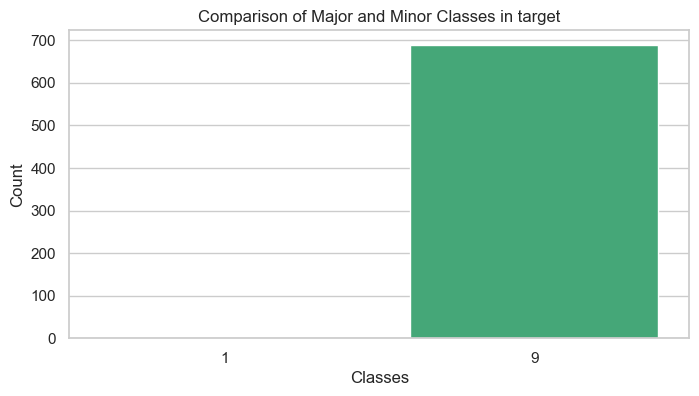

9 (Major Class): 689
1 (Minor Class): 1

#####################################################################################################

Cleaning Data...
Data cleaned.
Converting target column to categorical.
Basic Structure of the Data:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4177 entries, 0 to 4176
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Length          4177 non-null   float64
 1   Diameter        4177 non-null   float64
 2   Height          4177 non-null   float64
 3   Whole_weight    4177 non-null   float64
 4   Shucked_weight  4177 non-null   float64
 5   Viscera_weight  4177 non-null   float64
 6   Shell_weight    4177 non-null   float64
 7   target          4177 non-null   int32  
 8   Sex_I           4177 non-null   float64
 9   Sex_M           4177 non-null   float64
dtypes: float64(9), int32(1)
memory usage: 310.1 KB
None

##################################################

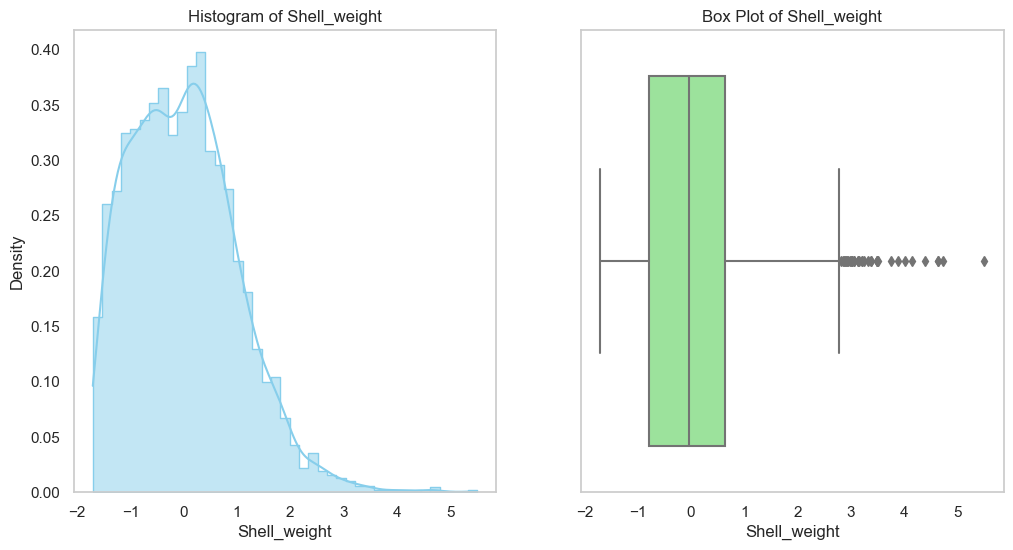

Plotting Histogram for Whole_weight
Plotting Box Plot for Whole_weight


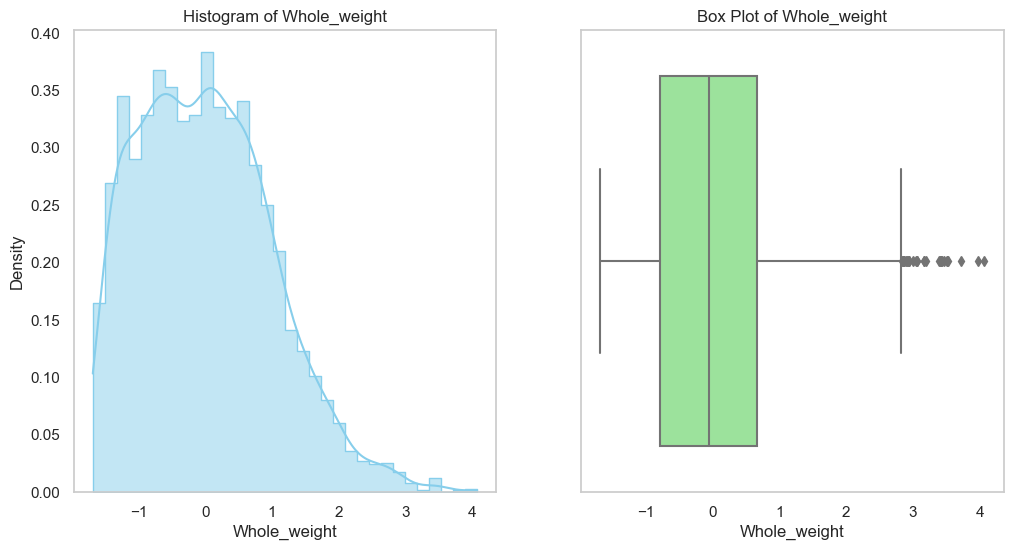

Plotting Histogram for Diameter
Plotting Box Plot for Diameter


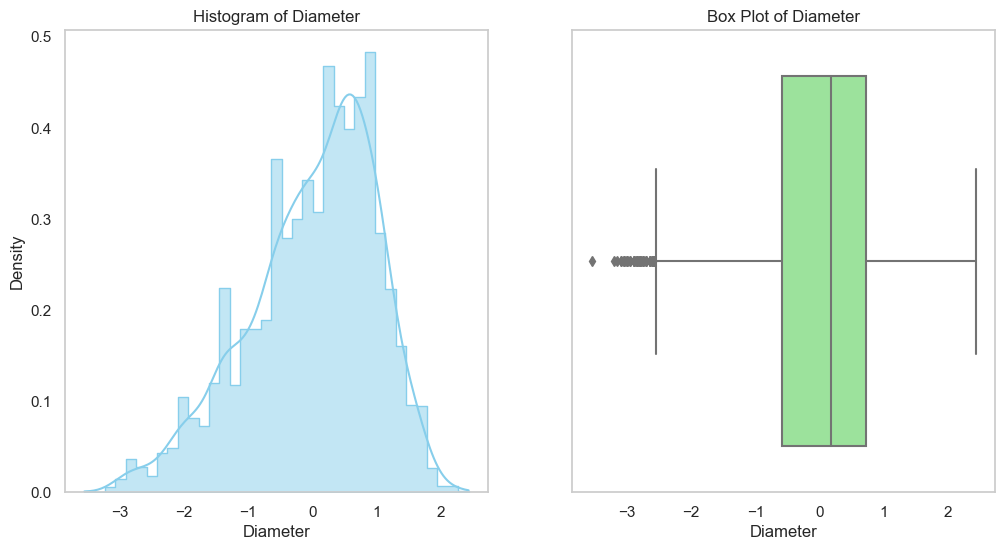

Plotting Histogram for Height
Plotting Box Plot for Height


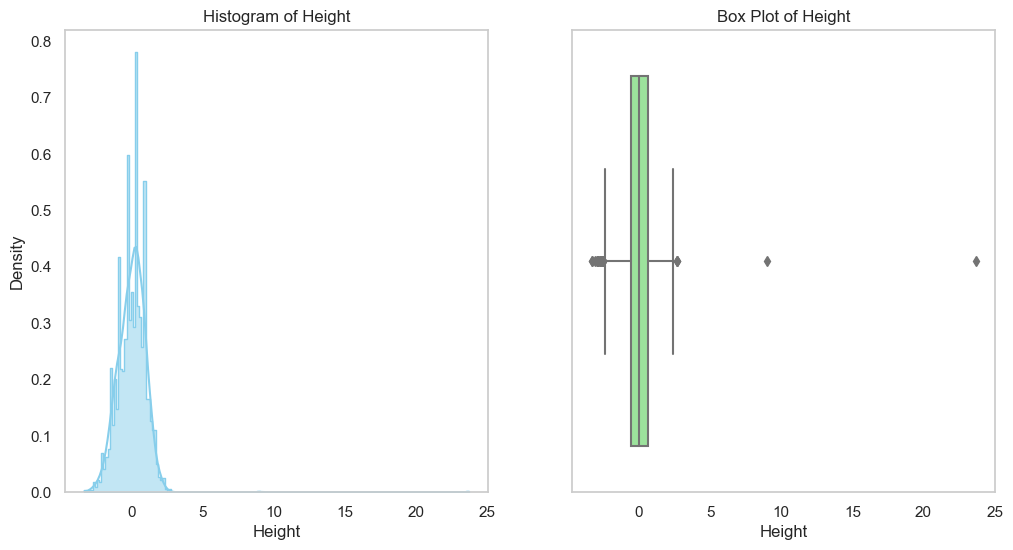

Plotting Histogram for Viscera_weight
Plotting Box Plot for Viscera_weight


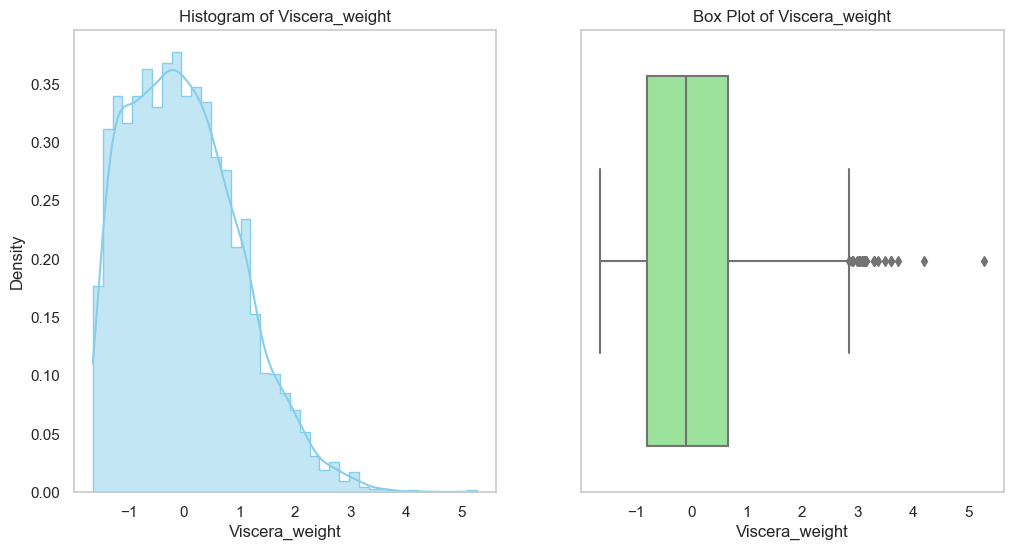


#####################################################################################################

Missing Values per Column:
Shell_weight      0
Whole_weight      0
Diameter          0
Height            0
Viscera_weight    0
target            0
dtype: int64

#####################################################################################################

Number of Unique Values per Column:
Shell_weight       926
Whole_weight      2429
Diameter           111
Height              51
Viscera_weight     880
target               3
dtype: int64

#####################################################################################################

Correlation Matrix of Important Columns:
Plotting Correlation Matrix


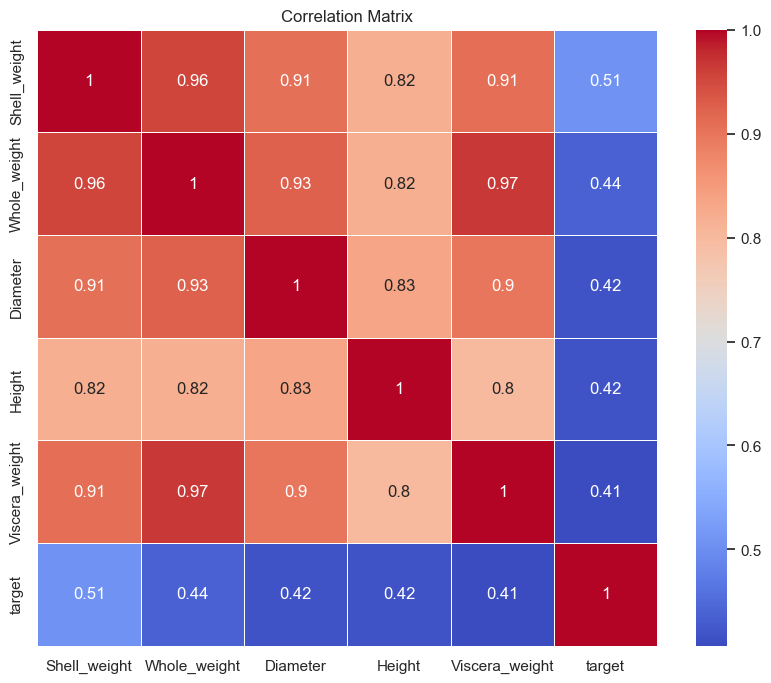


#####################################################################################################

Applying advanced balancing techniques...
Data type of target before modeling: int32


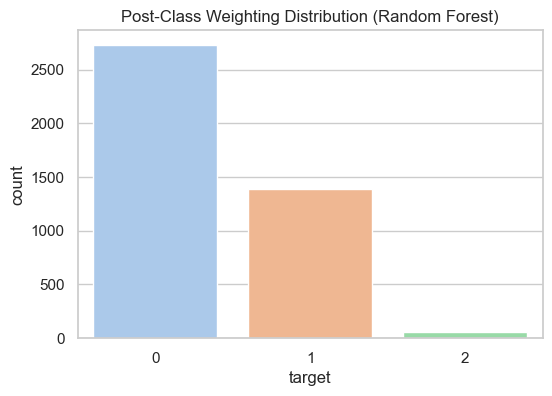

Balanced data saved to: Downloads\balanced_rf_data.csv


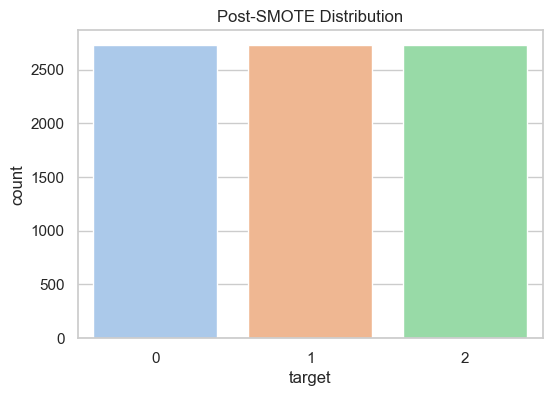

Balanced data saved to: Downloads\balanced_smote_data.csv


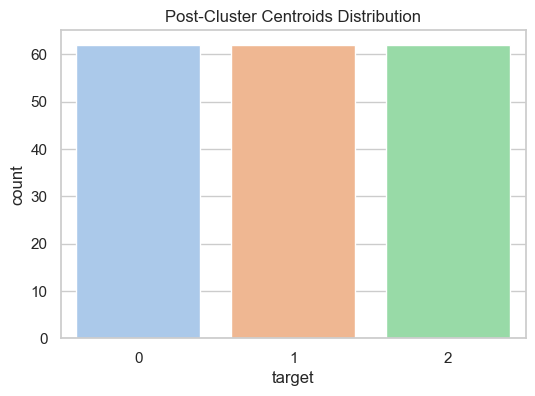

Balanced data saved to: Downloads\balanced_cc_data.csv


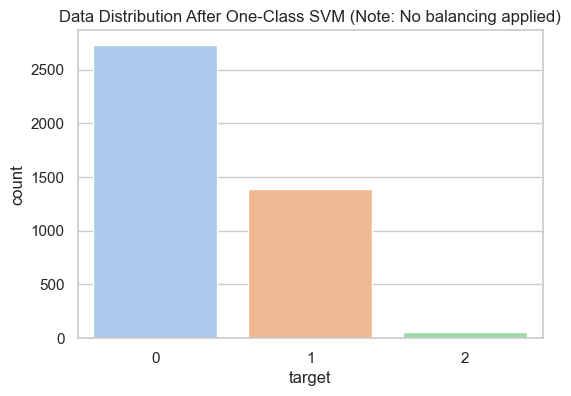

Data saved to: Downloads\svm_data.csv

Processing data balanced by Random Forest...
PCA applied, explained variance ratio (cumulative): 0.95
Applying feature selection...
Reduced feature set size: 1 from original 4
Training models for Random Forest balanced data...

Classification Report for Random Forest:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2730
           1       1.00      1.00      1.00      1385
           2       1.00      1.00      1.00        62

    accuracy                           1.00      4177
   macro avg       1.00      1.00      1.00      4177
weighted avg       1.00      1.00      1.00      4177


Classification Report for Logistic Regression:
              precision    recall  f1-score   support

           0       0.74      0.86      0.80      2730
           1       0.59      0.44      0.51      1385
           2       0.00      0.00      0.00        62

    accuracy                           0.71  

In [34]:

file_path = None #"AIDS.csv"  # Specify the actual file path
id_number = 1  # Change this to the dataset ID if you have one

# Call the Master function
Master(file_path=file_path, id=id_number)

# Source for Second Dataset: https://www.kaggle.com/datasets/mexwell/heart-disease-dataset

This dataset is about the **prediction of heart disease** consists of 1190 instances with 11 features. These datasets were collected and combined at one place to help advance research on CAD-related machine learning and data mining algorithms, and hopefully to ultimately advance clinical diagnosis and early treatment.

Data loaded from file at: heart_disease.csv
Columns in the dataset:
['age', 'sex', 'chest pain type', 'resting bp s', 'cholesterol', 'fasting blood sugar', 'resting ecg', 'max heart rate', 'exercise angina', 'oldpeak', 'ST slope', 'target']

Total columns loaded: 12
Dataset is balanced
Cleaning Data...
Data cleaned.
Converting target column to categorical.
Basic Structure of the Data:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1190 entries, 0 to 1189
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   age                  1190 non-null   float64
 1   sex                  1190 non-null   float64
 2   chest pain type      1190 non-null   float64
 3   resting bp s         1190 non-null   float64
 4   cholesterol          1190 non-null   float64
 5   fasting blood sugar  1190 non-null   float64
 6   resting ecg          1190 non-null   float64
 7   max heart rate       1190 non-null   float64
 8   

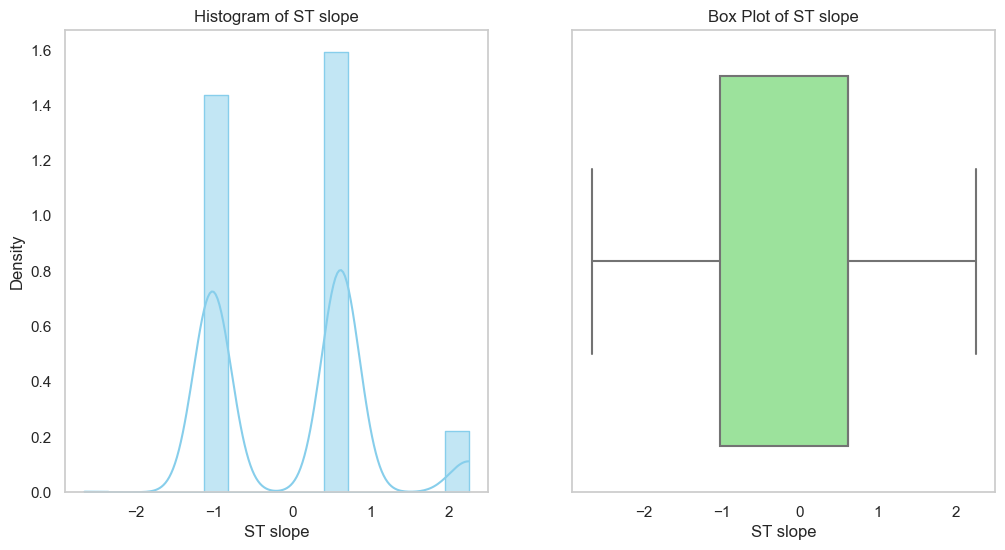

Plotting Histogram for exercise angina
Plotting Box Plot for exercise angina


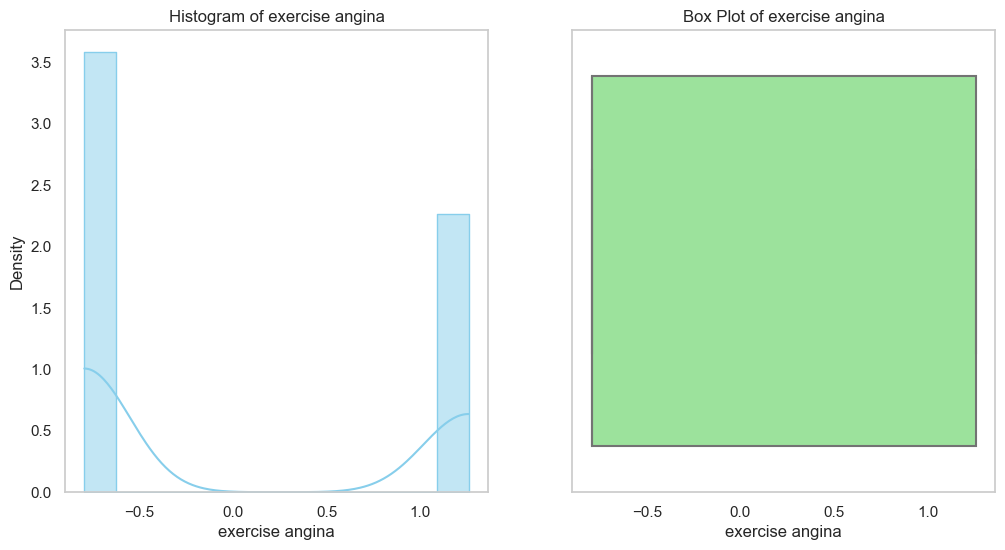

Plotting Histogram for chest pain type
Plotting Box Plot for chest pain type


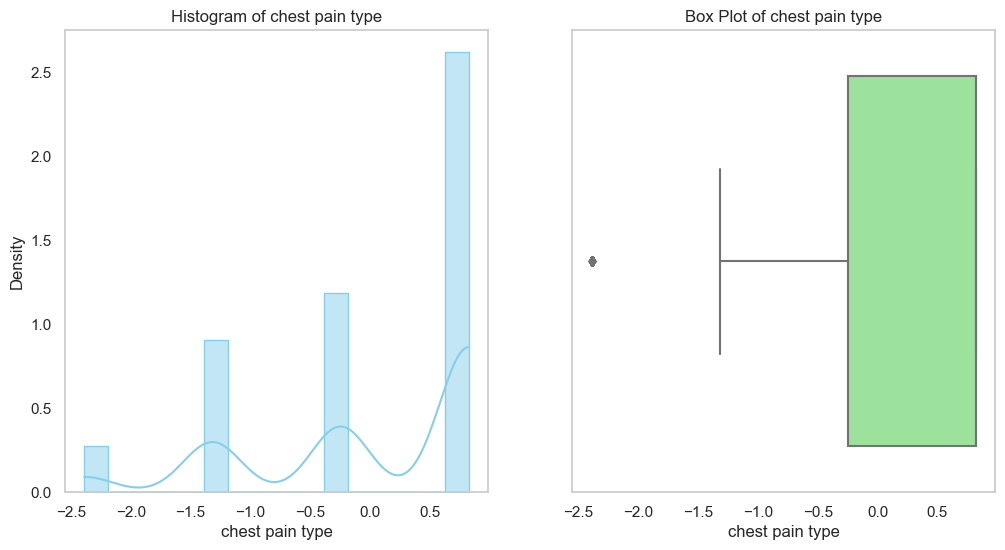

Plotting Histogram for max heart rate
Plotting Box Plot for max heart rate


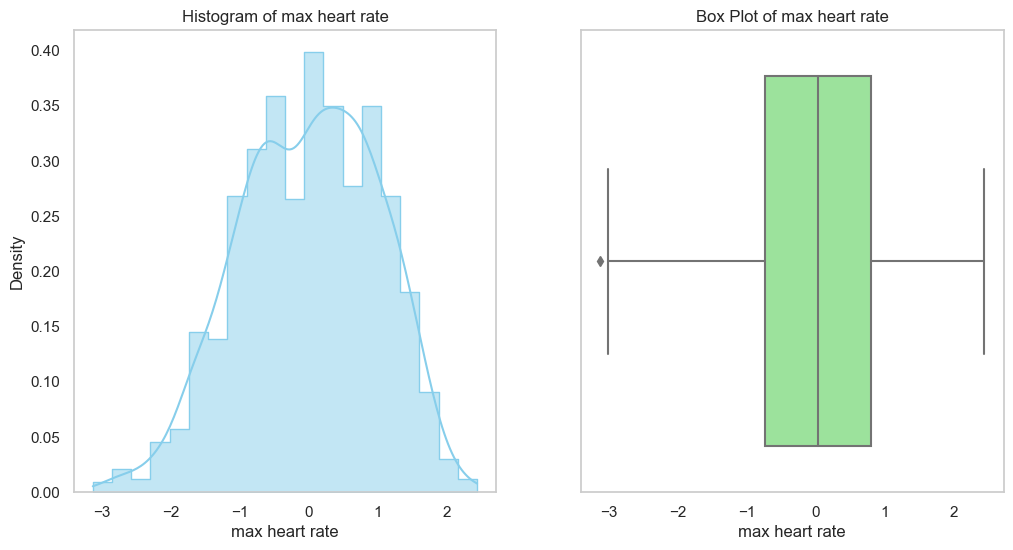

Plotting Histogram for oldpeak
Plotting Box Plot for oldpeak


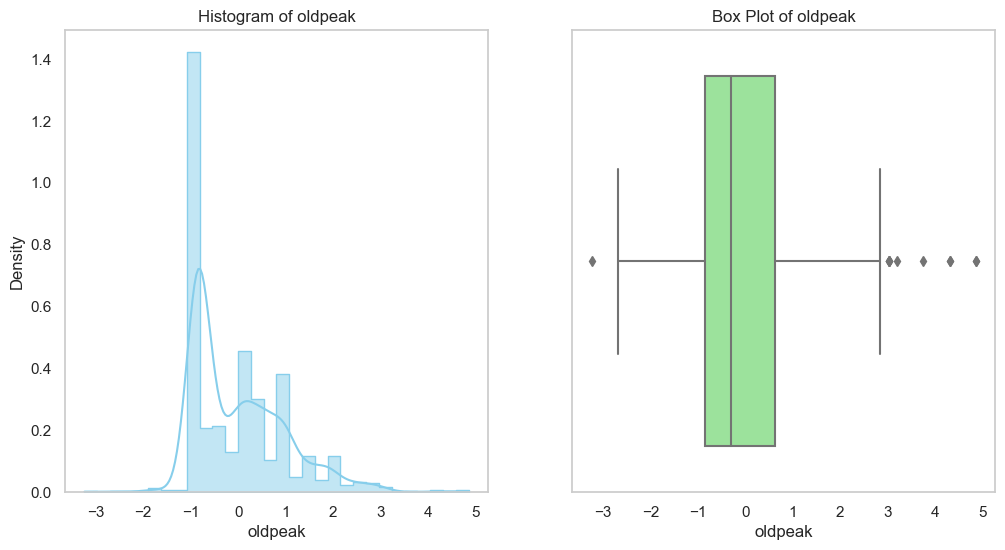


#####################################################################################################

Missing Values per Column:
ST slope           0
exercise angina    0
chest pain type    0
max heart rate     0
oldpeak            0
target             0
dtype: int64

#####################################################################################################

Number of Unique Values per Column:
ST slope             4
exercise angina      2
chest pain type      4
max heart rate     119
oldpeak             53
target               2
dtype: int64

#####################################################################################################

Correlation Matrix of Important Columns:
Plotting Correlation Matrix


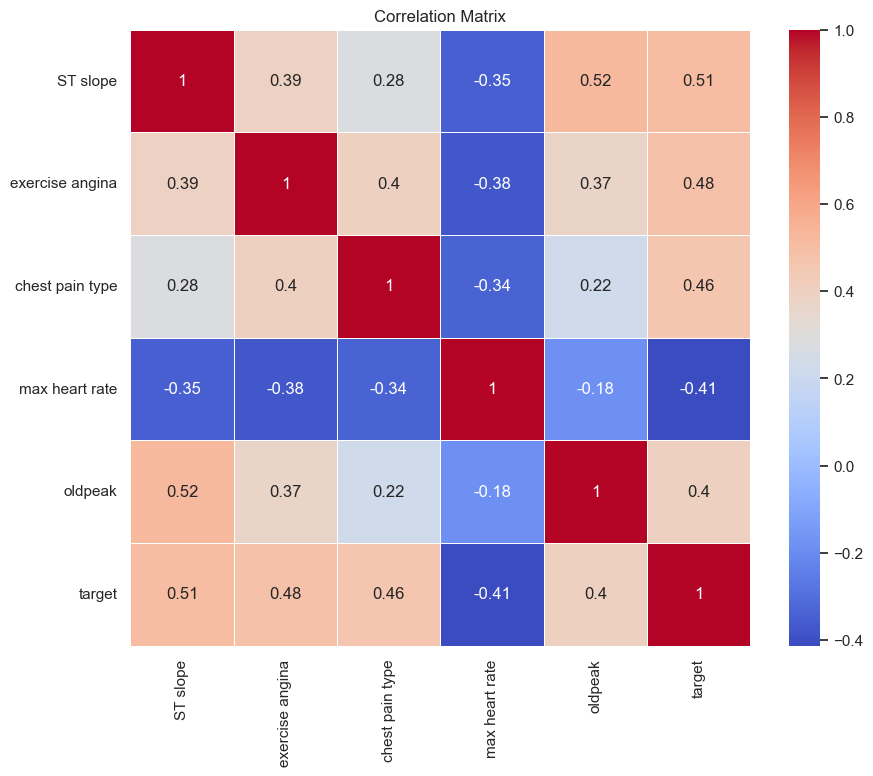


#####################################################################################################

Applying advanced balancing techniques...
Data type of target before modeling: int32


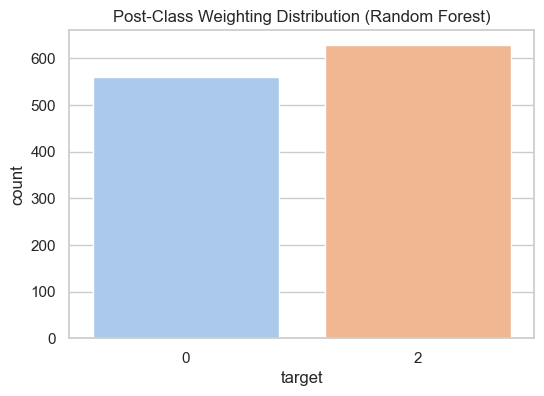

Balanced data saved to: Downloads\balanced_rf_data.csv


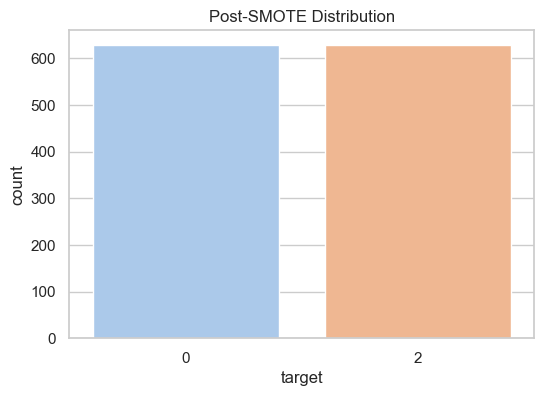

Balanced data saved to: Downloads\balanced_smote_data.csv


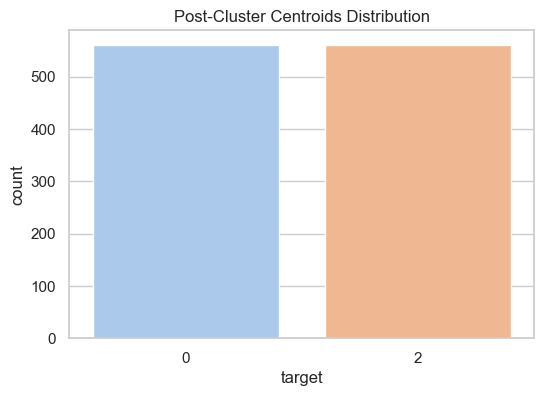

Balanced data saved to: Downloads\balanced_cc_data.csv


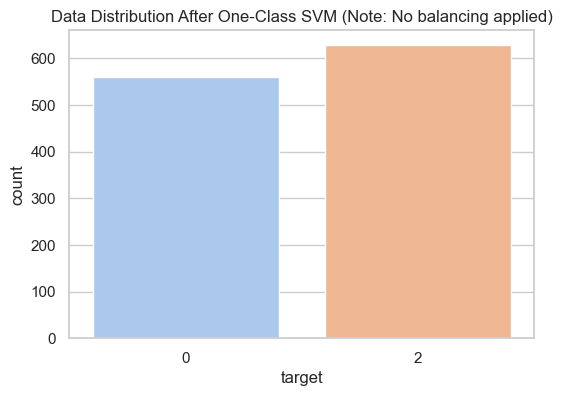

Data saved to: Downloads\svm_data.csv

Processing data balanced by Random Forest...
PCA applied, explained variance ratio (cumulative): 0.96
Applying feature selection...
Reduced feature set size: 1 from original 10
Training models for Random Forest balanced data...
Error calculating ROC AUC: y should be a 1d array, got an array of shape (1190, 2) instead.
Error calculating ROC AUC: y should be a 1d array, got an array of shape (1190, 2) instead.
Error calculating ROC AUC: y should be a 1d array, got an array of shape (1190, 2) instead.
Error calculating ROC AUC: y should be a 1d array, got an array of shape (1190, 2) instead.

Classification Report for Random Forest:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       561
           2       1.00      1.00      1.00       629

    accuracy                           1.00      1190
   macro avg       1.00      1.00      1.00      1190
weighted avg       1.00      1.00      1.00      11

In [35]:
file_path = "heart_disease.csv"  # Specify the actual file path
id_number = None  # Change this to the dataset ID if you have one

# Call the Master function
Master(file_path=file_path, id=id_number)

# Source for third Dataset: https://www.kaggle.com/datasets/aadarshvelu/aids-virus-infection-prediction


This Dataset contains healthcare statistics and categorical information about patients who have been diagnosed with AIDS. This dataset was initially published in 1996. The learning will show if the **patients will have AIDS or not** based on the several parameters

Dataset is imbalanced with an imbalance ratio of 2.22


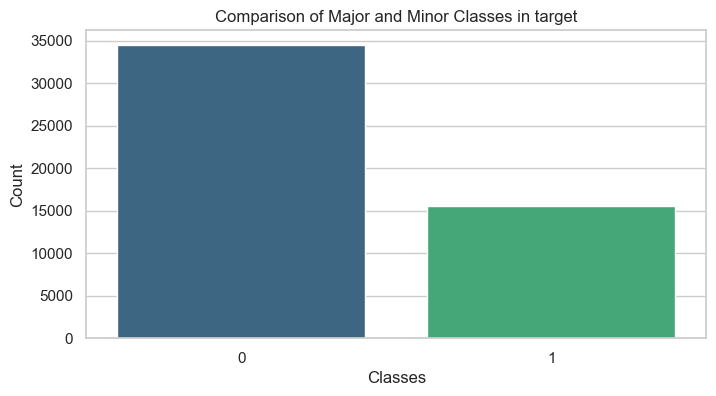

0 (Major Class): 34494
1 (Minor Class): 15506

#####################################################################################################

Cleaning Data...
Data cleaned.
Converting target column to categorical.
Basic Structure of the Data:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 23 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   time     50000 non-null  float64
 1   trt      50000 non-null  float64
 2   age      50000 non-null  float64
 3   wtkg     50000 non-null  float64
 4   hemo     50000 non-null  float64
 5   homo     50000 non-null  float64
 6   drugs    50000 non-null  float64
 7   karnof   50000 non-null  float64
 8   oprior   50000 non-null  float64
 9   z30      50000 non-null  float64
 10  preanti  50000 non-null  float64
 11  race     50000 non-null  float64
 12  gender   50000 non-null  float64
 13  str2     50000 non-null  float64
 14  strat    50000 non-null  fl

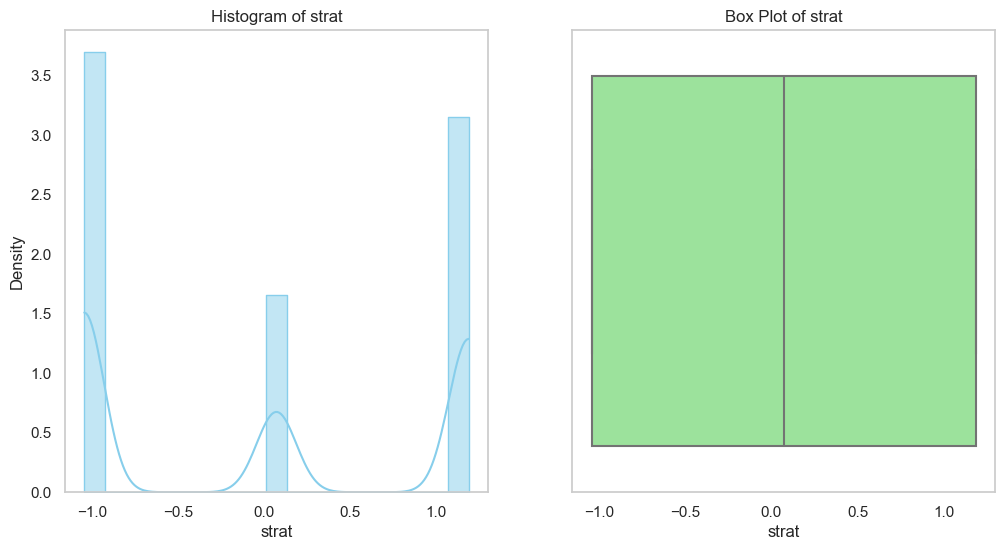

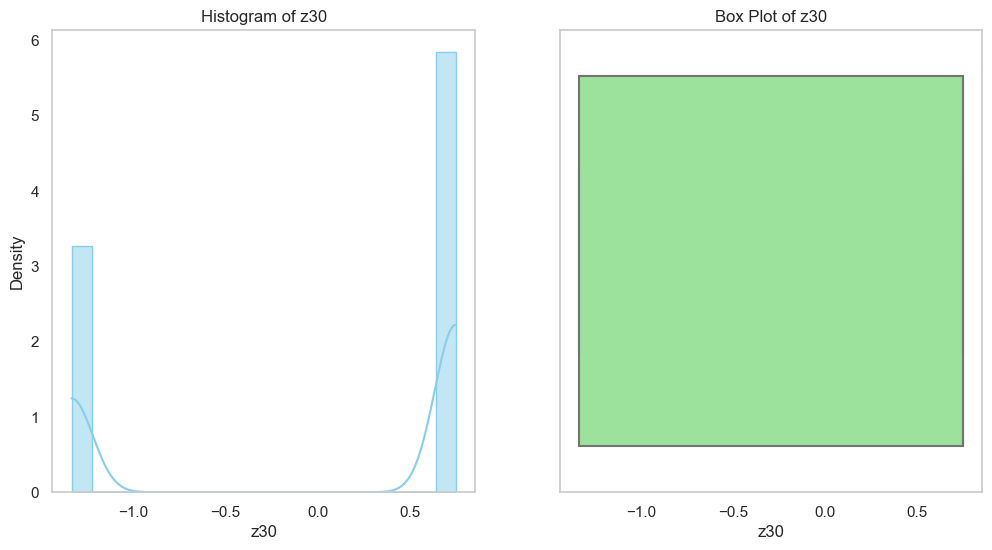

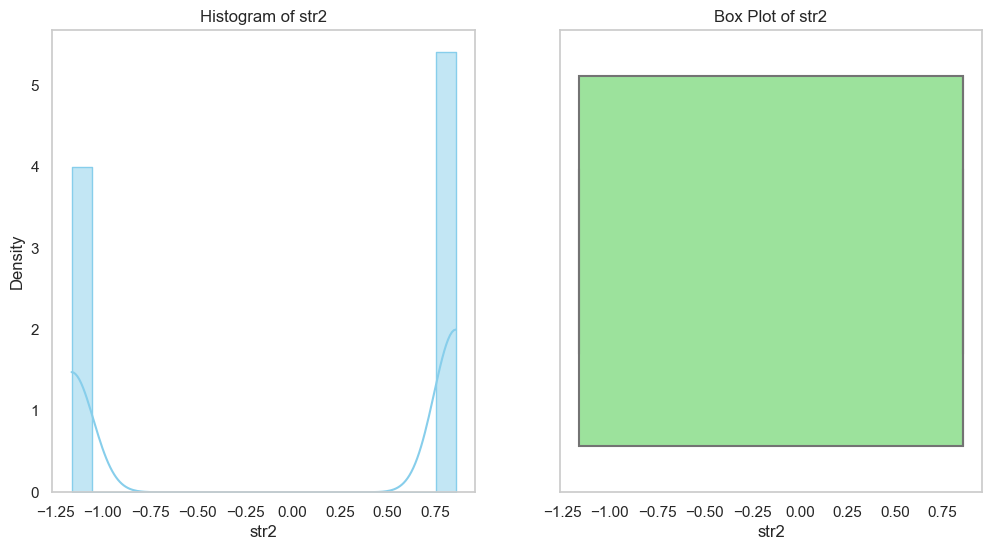

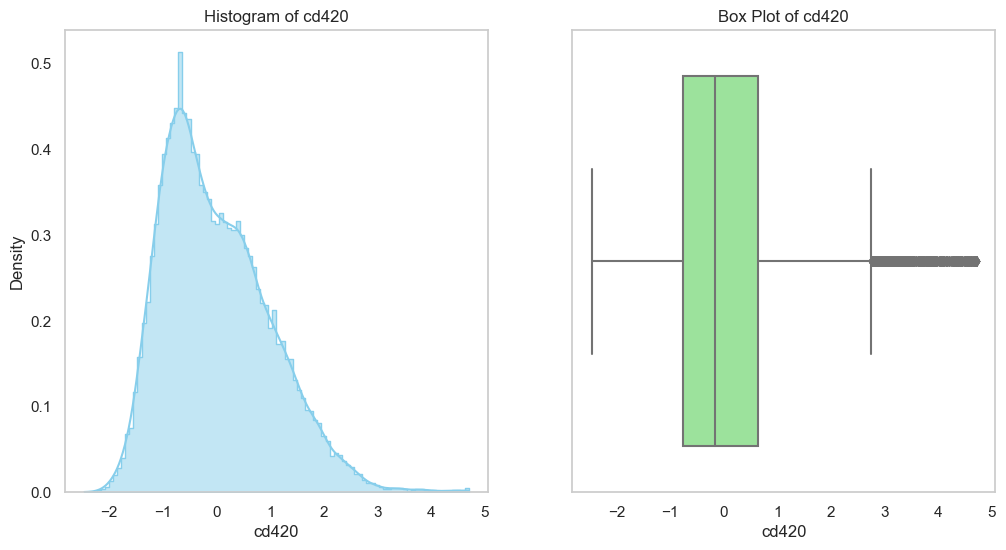

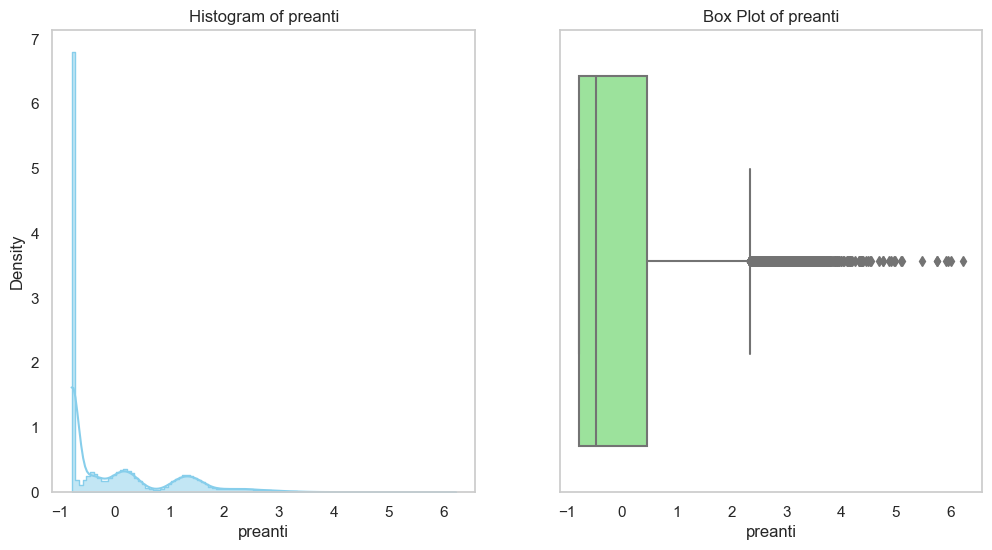


#####################################################################################################

Missing Values per Column:
strat      0
z30        0
str2       0
cd420      0
preanti    0
target     0
dtype: int64

#####################################################################################################

Number of Unique Values per Column:
strat         3
z30           2
str2          2
cd420       902
preanti    1775
target        2
dtype: int64

#####################################################################################################

Correlation Matrix of Important Columns:


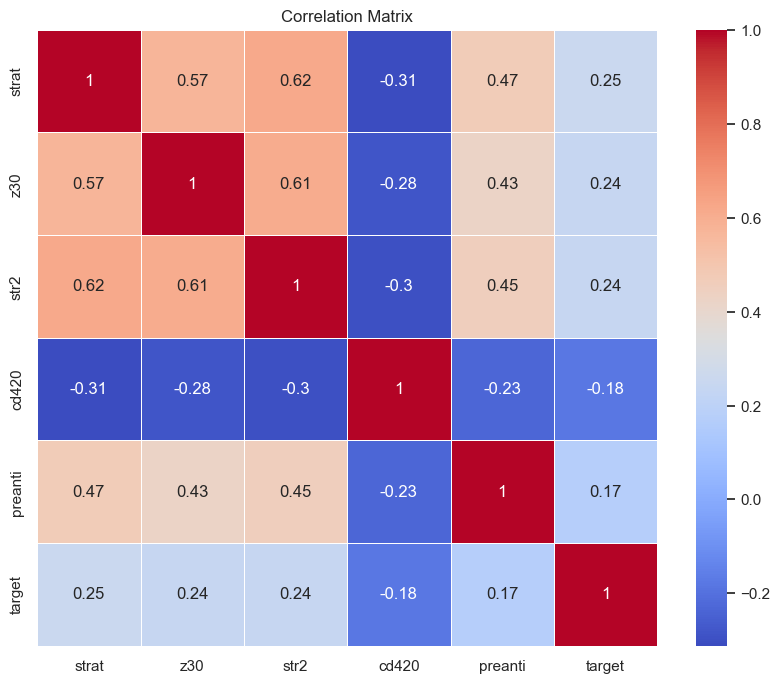


#####################################################################################################

Applying advanced balancing techniques...
Data type of target before modeling: int32


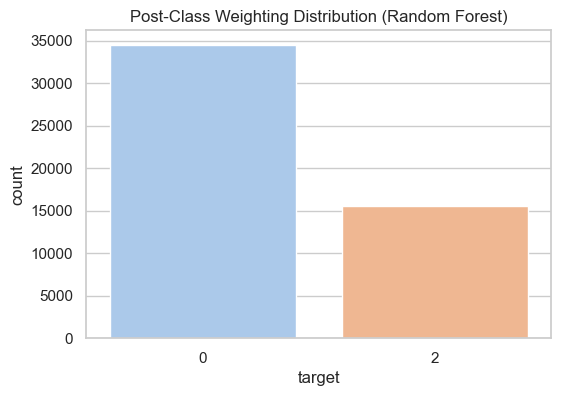

Balanced data saved to: Downloads\balanced_rf_data.csv


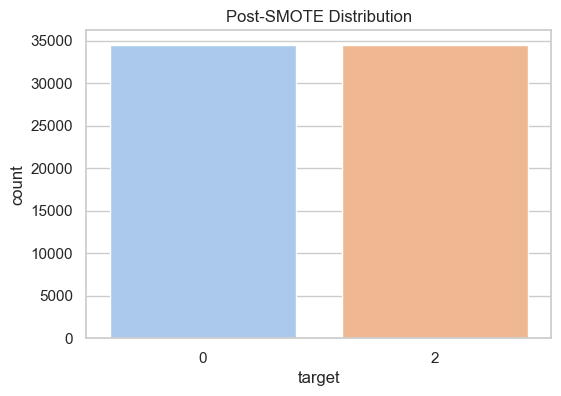

Balanced data saved to: Downloads\balanced_smote_data.csv


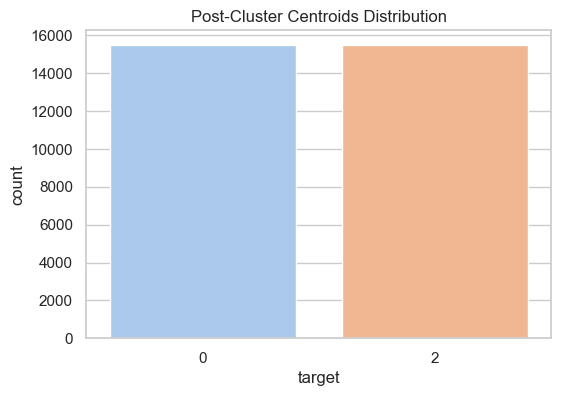

Balanced data saved to: Downloads\balanced_cc_data.csv


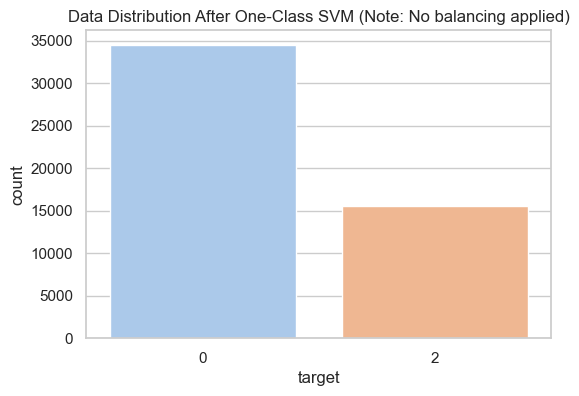

Data saved to: Downloads\svm_data.csv

Processing data balanced by Random Forest...
PCA applied, explained variance ratio (cumulative): 0.96
Applying feature selection...
Reduced feature set size: 3 from original 20
Training models for Random Forest balanced data...

Classification Report for Random Forest:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     34494
           2       1.00      1.00      1.00     15506

    accuracy                           1.00     50000
   macro avg       1.00      1.00      1.00     50000
weighted avg       1.00      1.00      1.00     50000


Classification Report for Logistic Regression:
              precision    recall  f1-score   support

           0       0.73      0.93      0.81     34494
           2       0.58      0.22      0.32     15506

    accuracy                           0.71     50000
   macro avg       0.65      0.57      0.57     50000
weighted avg       0.68      0.71      0.66 

In [17]:
file_path = "AIDS.csv"  # Specify the actual file path
id_number = None  # Change this to the dataset ID if you have one

# Call the Master function
Master(file_path=file_path, id=id_number)

# Source for fourth Dataset: https://www.kaggle.com/datasets/ahsan81/superstore-marketing-campaign-dataset

The **superstore** wants to **predict the likelihood of the customer** giving a **positive response** and wants to identify the different factors which affect the customer's response. You need to analyze the data provided to identify these factors and then build a prediction model to predict the probability of a customer will give a **positive response.**

Data loaded from file at: superstore_data.csv
Columns in the dataset:
['Id', 'Year_Birth', 'Education', 'Marital_Status', 'Income', 'Kidhome', 'Teenhome', 'Dt_Customer', 'Recency', 'MntWines', 'MntFruits', 'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts', 'MntGoldProds', 'NumDealsPurchases', 'NumWebPurchases', 'NumCatalogPurchases', 'NumStorePurchases', 'NumWebVisitsMonth', 'target']

Total columns loaded: 21
Dataset is imbalanced with an imbalance ratio of 5.71


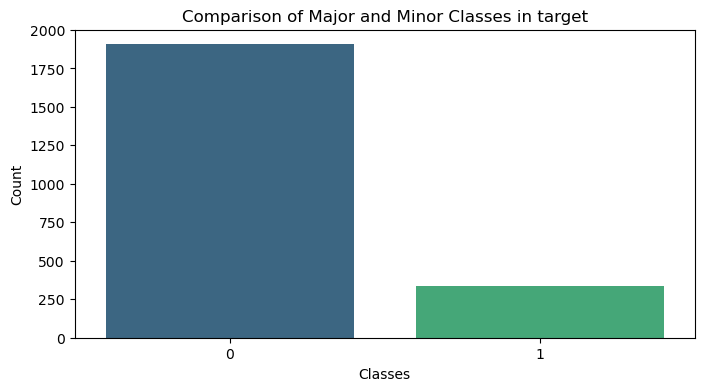

0 (Major Class): 1906
1 (Minor Class): 334

#####################################################################################################

Cleaning Data...
Data cleaned.
Converting target column to categorical.
Basic Structure of the Data:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2240 entries, 0 to 2239
Columns: 691 entries, Id to Dt_Customer_9/9/2013
dtypes: float64(690), int32(1)
memory usage: 11.8 MB
None

#####################################################################################################

Descriptive Statistics for Numeric Data:
                 Id    Year_Birth        Income       Kidhome      Teenhome  \
count  2.240000e+03  2.240000e+03  2.240000e+03  2.240000e+03  2.240000e+03   
mean   1.586033e-17 -8.136349e-15  4.440892e-17 -2.696256e-17 -6.344132e-18   
std    1.000223e+00  1.000223e+00  1.000223e+00  1.000223e+00  1.000223e+00   
min   -1.722818e+00 -6.326960e+00 -2.018090e+00 -8.252176e-01 -9.298944e-01   
25%   -8.514982e-01 -8.184192e-

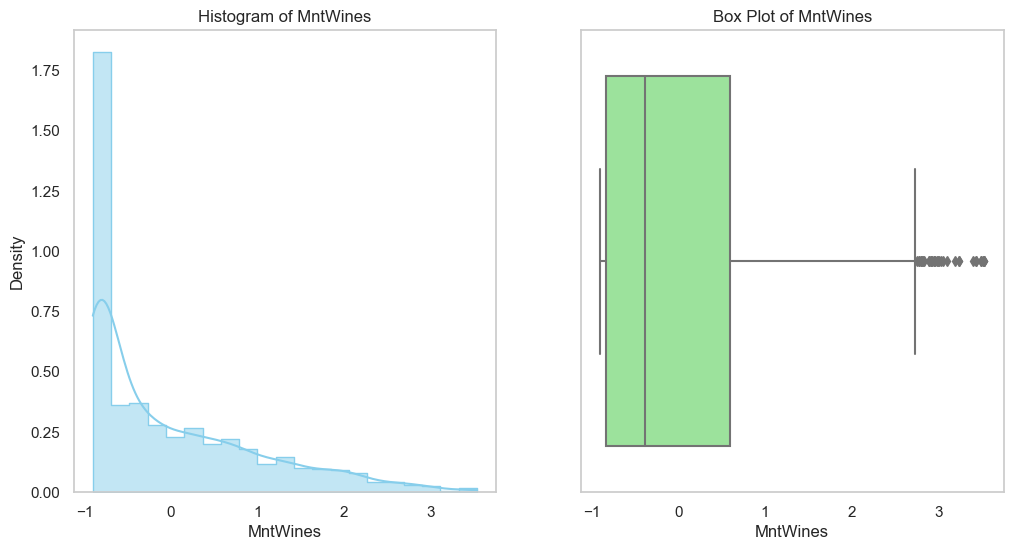

Plotting Histogram for MntMeatProducts
Plotting Box Plot for MntMeatProducts


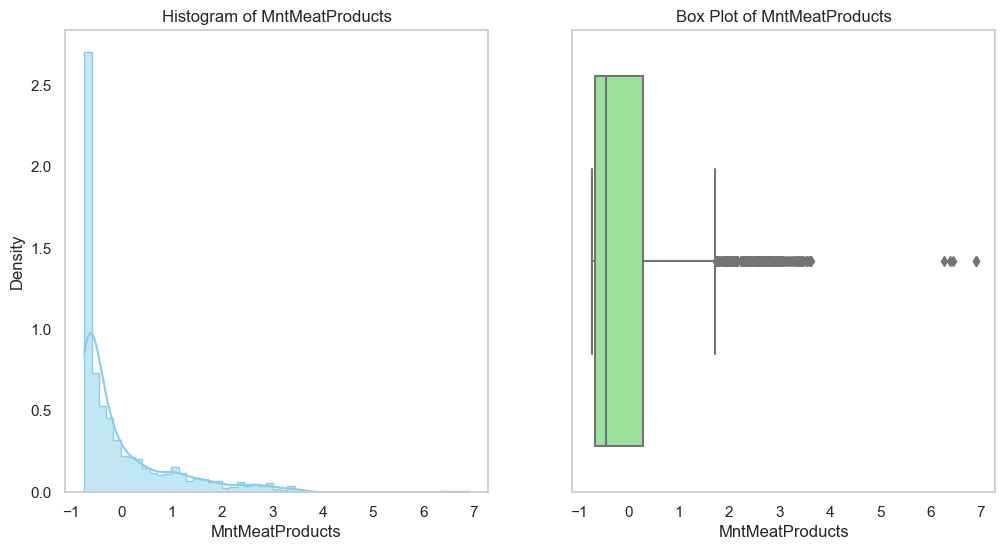

Plotting Histogram for NumCatalogPurchases
Plotting Box Plot for NumCatalogPurchases


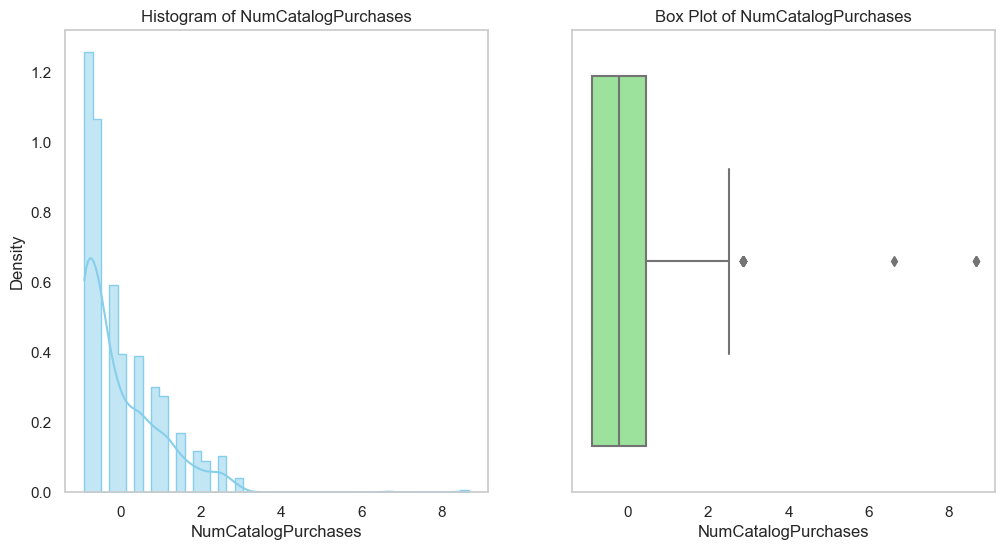

Plotting Histogram for Recency
Plotting Box Plot for Recency


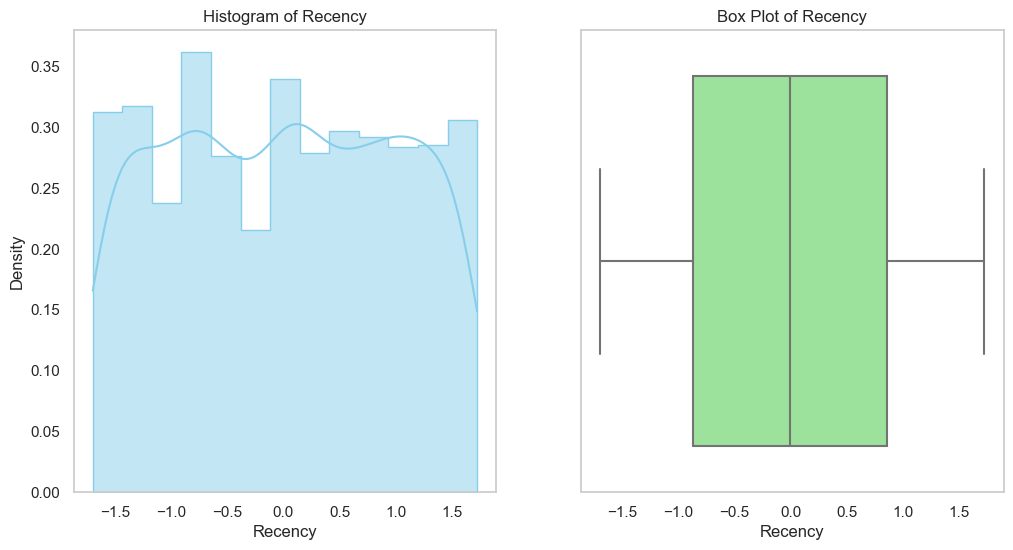

Plotting Histogram for Teenhome
Plotting Box Plot for Teenhome


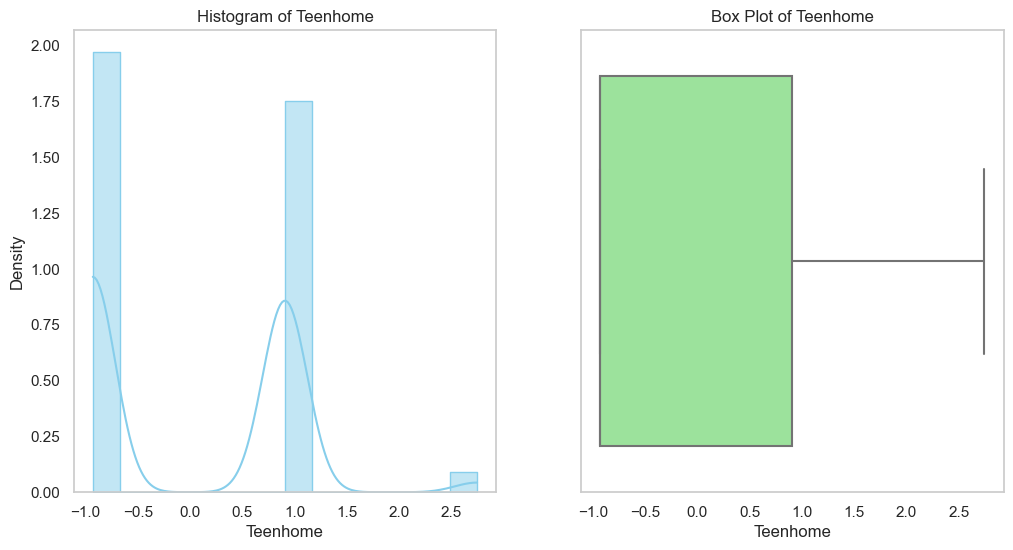


#####################################################################################################

Missing Values per Column:
MntWines               0
MntMeatProducts        0
NumCatalogPurchases    0
Recency                0
Teenhome               0
target                 0
dtype: int64

#####################################################################################################

Number of Unique Values per Column:
MntWines               776
MntMeatProducts        558
NumCatalogPurchases     14
Recency                100
Teenhome                 3
target                   2
dtype: int64

#####################################################################################################

Correlation Matrix of Important Columns:
Plotting Correlation Matrix


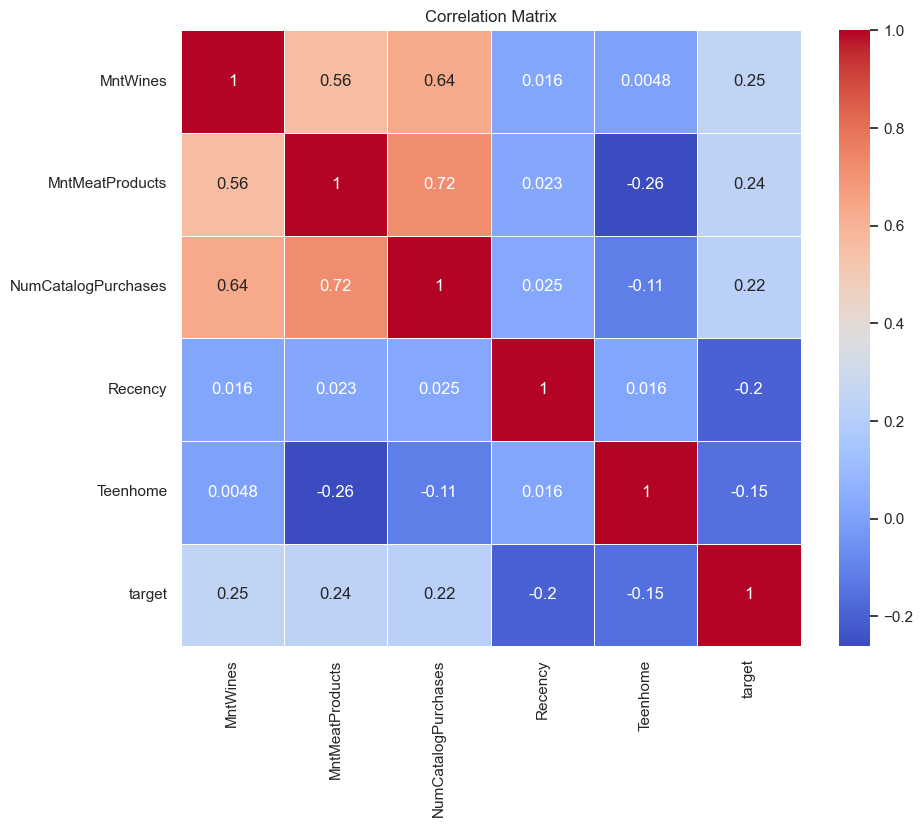


#####################################################################################################

Applying advanced balancing techniques...
Data type of target before modeling: int32


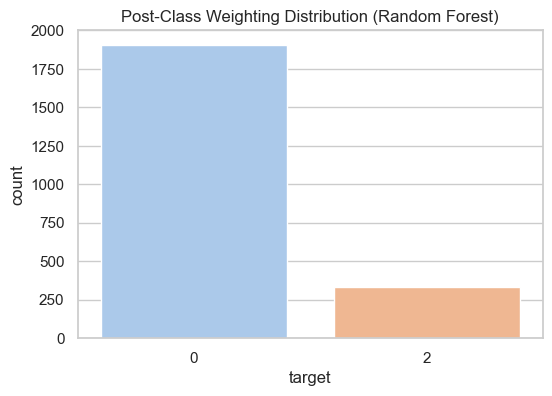

Balanced data saved to: Downloads\balanced_rf_data.csv


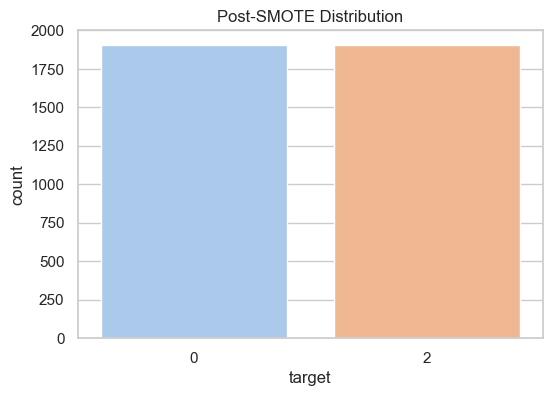

Balanced data saved to: Downloads\balanced_smote_data.csv


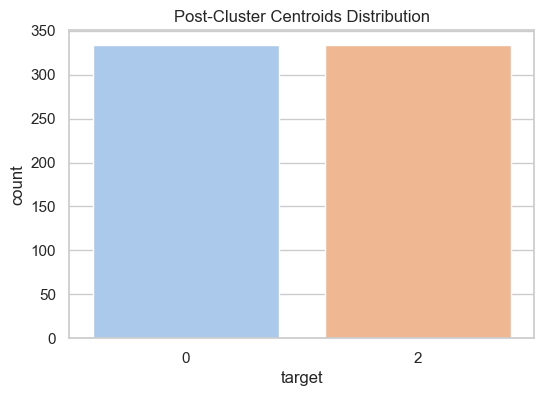

Balanced data saved to: Downloads\balanced_cc_data.csv


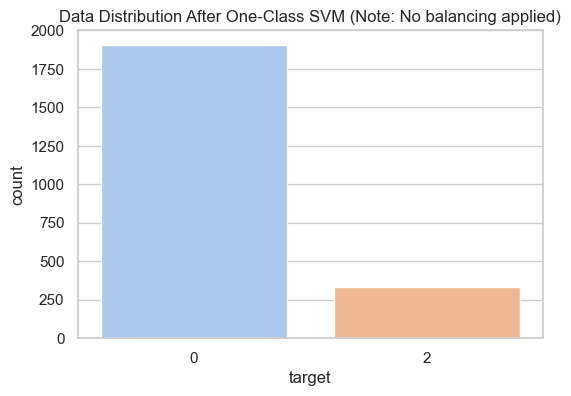

Data saved to: Downloads\svm_data.csv

Processing data balanced by Random Forest...
PCA applied, explained variance ratio (cumulative): 0.95
Applying feature selection...
Reduced feature set size: 3 from original 30
Training models for Random Forest balanced data...
Error calculating ROC AUC: y should be a 1d array, got an array of shape (2240, 2) instead.
Error calculating ROC AUC: y should be a 1d array, got an array of shape (2240, 2) instead.
Error calculating ROC AUC: y should be a 1d array, got an array of shape (2240, 2) instead.
Error calculating ROC AUC: y should be a 1d array, got an array of shape (2240, 2) instead.

Classification Report for Random Forest:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1906
           2       1.00      1.00      1.00       334

    accuracy                           1.00      2240
   macro avg       1.00      1.00      1.00      2240
weighted avg       1.00      1.00      1.00      22

In [16]:
file_path = "superstore_data.csv"  # Specify the actual file path
id_number = None  # Change this to the dataset ID if you have one

# Call the Master function
Master(file_path=file_path, id=id_number)